In [6]:
using Pkg; Pkg.activate()

using Plots
using Convex, ECOS  # Convex modeling and solver
using Distributions, Random  # Seeds and sampling
using LightGraphs  # Generating nice random graphs
using GraphPlot, Colors  # For plotting
using SparseArrays

OPT = () -> ECOS.Optimizer(verbose=false)

#3 (generic function with 1 method)

# Generate some random data

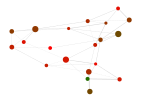

In [48]:
Random.seed!(2)
n = 20
l = 50

# Make graph
G = watts_strogatz(n, 4, 0.2)

# Convert to incidence matrix
A = incidence_matrix(G, oriented=true)
m = size(A, 2)

# Create generator-node mapping
node_map = vcat(collect(1:n), rand(1:n, l-n))
B = spzeros(n, l)
for (gen, node) in enumerate(node_map)
    B[node, gen] = 1
end

# Generate carbon costs
cq = zeros(l)
cl = rand(Exponential(2), l)

# Generate demands
d = rand(Bernoulli(0.8), n) .* rand(Gamma(3.0, 3.0), n)

# Generate generation and flow capacities
gmax = rand(Gamma(4.0, 3.0), l) + (B'd)  # This is just to make the problem easier
pmax = rand(Gamma(1.0, 1.0), m)

# Plot network
c_node = (B*cl) ./ (B*ones(l))
nodesize = maximum(d) .+ d
nodefillc = weighted_color_mean.((c_node / maximum(c_node)).^0.5, colorant"red", colorant"green")
edgelinewidth = (pmax / maximum(pmax)).^0.5

Random.seed!(0)  # I put a seed here so the spring layout doesn't change
plt = gplot(G, nodesize=nodesize, nodefillc=nodefillc, edgelinewidth=edgelinewidth)

# Solve the carbon management problem

In [36]:
using Revise
using CarbonNetworks

In [49]:
cnet = PowerNetwork(cq, cl, pmax, gmax, A, B)
carbon_min = PowerManagementProblem(cnet, d)
solve!(carbon_min, OPT, verbose=true);

# Plot results

`GraphPlot` is only for making simple plots. To do more advanced things (like the plot in the carbon accounting paper), we'll need to draw the graph manually.

For now, I'm going to make some simple diagnostic plots.

## Plot demand, generation, and LMPs

Here, the LMPs are carbon LMPs.

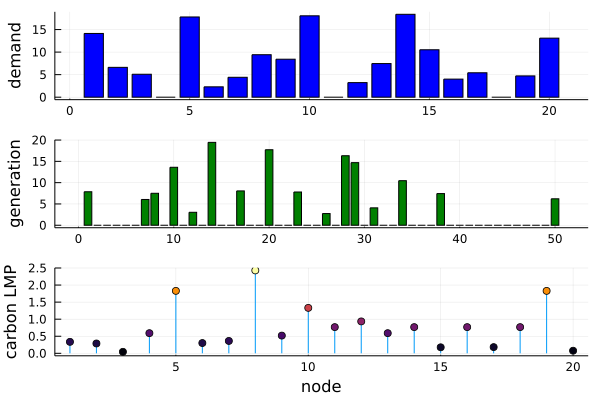

In [50]:
λ = get_lmps(carbon_min)  # <-- LMPs

# Fancy colors
gradient = cgrad(:inferno)
lmp_colors = [get(gradient, λi/maximum(λ)) for λi in λ]


plt1 = bar(d, label=nothing, c=:blue, ylabel="demand")
plt2 = bar(evaluate(carbon_min.g), label=nothing, c=:green, ylabel="generation")
plt3 = sticks(λ, label=nothing, ylabel="carbon LMP", xlabel="node")
scatter!(plt3, λ, c=lmp_colors, label=nothing)

plot(plt1, plt2, plt3, layout=(3, 1))

## Plot carbon LMPs

Brighter is more carbon intensive. At the bright nodes (orange and yellow), increasing / decreasing demand has the greatest effect on total emissions.

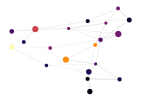

In [51]:
Random.seed!(0)  # <-- For the node layout consistency
plt = gplot(G, nodesize=nodesize, nodefillc=lmp_colors, edgelinewidth=edgelinewidth)

# Implicit diff

In [68]:
using CarbonNetworks: kkt, flatten_variables

Random.seed!(4)

fq = 2 .+ rand(Exponential(3), l)  # generate monetary costs
fl = 2 .+ rand(Exponential(3), l)

# Solve cost minimization problem
net = PowerNetwork(fq, fl, pmax, gmax, A, B)
opf = PowerManagementProblem(net, d)
solve!(opf, OPT, verbose=true)

kkt_resid = kkt(flatten_variables(opf), net, d)
@show norm(kkt_resid)

norm(kkt_resid) = 0.0065154090711841035


0.0065154090711841035

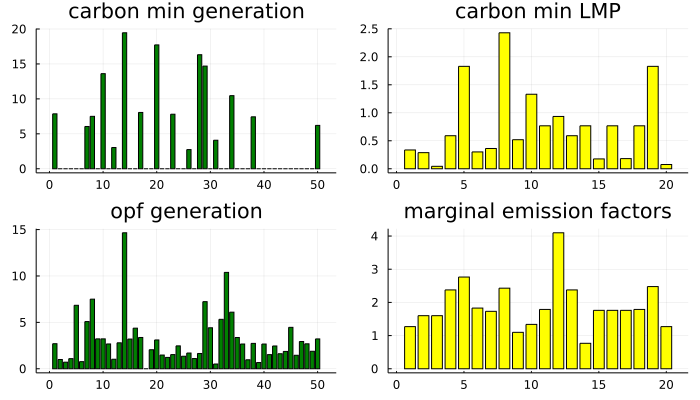

In [70]:
∇C = zeros(kkt_dims(n, m, l))
∇C[1:l] .= cl

mefs = sensitivity_demand(opf, ∇C, net, d)

theme(:default, legend=false)
plt1a = bar(evaluate(carbon_min.g), title="carbon min generation", color=:green)
plt1b = bar(get_lmps(carbon_min), title="carbon min LMP", color=:yellow)
plt2a = bar(evaluate(opf.g), title="opf generation", color=:green)
plt2b = bar(mefs, title="marginal emission factors", color=:yellow)
plot(plt1a, plt1b, plt2a, plt2b, layout=(2, 2), size=(700, 400))

# Compute MEFs via regression

In [ ]:
using CarbonNetworks: solve_pmp

Random.seed!(14)

num_cases = 1000
ϵ = 0.05

d_hidden = gmax / 2

cases = []
for _ in 1:num_cases
    d_hidden *= rand(Uniform(0.95, 1.05))
    d_obs = d_hidden + ϵ*randn(n)
    
    g, pmp, _ = solve_pmp(fq, fl, d_obs, pmax, gmax, A)
    if Int(pmp.problem.status) ∉ [1, 7]
        @show pmp.problem.status
    end
    
    push!(cases, (d=d_obs, g=g, pmp=pmp))
end

In [ ]:
Random.seed!(41)
inds = sample(1:50, 5, replace=false)

theme(:default, label=nothing, lw=4)
plot([d[i] for (d, g) in cases, i in inds], labels=inds')

In [ ]:
E = [c'g for (d, g) in cases]

Δd = hcat([cases[t].d - cases[t-1].d for t in 2:num_cases]...)
ΔE = [E[t] - E[t-1] for t in 2:num_cases];

In [ ]:
i = 30

μi = Δd[i, :] \ ΔE
ΔE_est = Δd[i, :] * μi
correlation = cor(ΔEi_est, ΔE)

@show μi

μi_diff = 0

for case in cases[1:1]
    params = (fq, fl, case.d, pmax, gmax, A)
    ∇C = zeros(kkt_dims(n, m))
    ∇C[1:n] .= cl
    
    mefs = sensitivity_demand(case.pmp, ∇C, params...)
    μi_diff += mefs[i] #/ length(cases)
end

@show μi_diff

In [ ]:
x_coords = Δd[i, :]

scatter(x_coords, ΔE, xlabel="Δd", ylabel="ΔE")
plot!(x_coords, ΔE_est, label="r2=$(round(correlation, digits=2))", legend=:topleft)
#plot!(x_coords, μi_diff*x_coords)